In [1]:
import numpy as np
import torch

layers = [(25,4),(10,25),(2,10)]

def model(x, unpacked_params):
  l1, b1, l2, b2, l3, b3 = unpacked_params
  y = torch.nn.functional.linear(x, l1, b1)
  y = torch.relu(y)
  y = torch.nn.functional.linear(y, l2, b2)
  y = torch.relu(y)
  y = torch.nn.functional.linear(y, l3, b3)
  y = torch.log_softmax(y, dim=0)
  return y

def unpack_params(params, layers=layers):
  unpacked_params = []
  e = 0
  for i, l in enumerate(layers):
    s, e = e, e+np.prod(l)
    weights = params[s:e].view(l)
    s, e = e, e+l[0]
    bias = params[s:e]
    unpacked_params.extend([weights, bias])
  return unpacked_params

def spawn_population(N=50, size=407):
  pop = []
  for i in range(N):
    vec = torch.randn(size) / 2.0
    fit = 0
    p = {'params':vec, 'fitness':fit}
    pop.append(p)
  return pop

def recombine(x1, x2):
  x1 = x1['params']
  x2 = x2['params']
  e = 0
  length = len(x1)
  child1 = torch.zeros(length)
  child2 = torch.zeros(length)
  
  for i, l in enumerate(layers):
    s, e = e, e+np.prod(l)+l[0]
    split_pt = s + np.random.randint(e - s)
    child1[s:split_pt] = x1[s:split_pt]
    child1[split_pt:] = x2[split_pt:]
    child2[s:split_pt] = x2[s:split_pt]
    child2[split_pt:] = x1[split_pt:]
    
  c1 = {'params':child1, 'fitness':0.0}
  c2 = {'params':child2, 'fitness':0.0}
  return c1, c2

def mutate(x, rate=0.01):
  x_ = x['params']
  num_to_change = int(rate * x_.shape[0])
  idx = np.random.randint(low=0, high=x_.shape[0], size=(num_to_change,))
  x_[idx] = torch.randn(num_to_change) / 10.0
  x['params'] = x_
  return x

In [2]:
import gym

env = gym.make("CartPole-v0")

def test_model(agent):
  done = False
  state = torch.from_numpy(env.reset()).float()
  score = 0
  while not done:
    params = unpack_params(agent['params'])
    probs = model(state, params)
    action = torch.distributions.Categorical(probs=probs).sample()
    state_, reward, done, info = env.step(action.item())
    state = torch.from_numpy(state_).float()
    score += 1
  return score

def evaluate_population(pop):
  tot_fit = 0
  lp = len(pop)
  for agent in pop:
    score = test_model(agent)
    agent['fitness'] = score
    tot_fit += score
  avg_fit = tot_fit / lp
  return pop, avg_fit

def next_generation(pop, mut_rate=0.001, tournament_size = 0.2):
  new_pop = []
  lp = len(pop)
  while len(new_pop) < len(pop):
    rids = np.random.randint(low=0, high=lp, size=(int(tournament_size * lp)))
    batch = np.array([[i, x['fitness']] for (i, x) in enumerate(pop) if i in rids])
    scores = batch[batch[:, 1].argsort()]
    i0, i1 = int(scores[-1][0]), int(scores[-2][0])
    parent0, parent1 = pop[i0], pop[i1]
    offspring_ = recombine(parent0, parent1)
    child1 = mutate(offspring_[0], rate=mut_rate)
    child2 = mutate(offspring_[1], rate=mut_rate)
    offspring = [child1, child2]
    new_pop.extend(offspring)
  return new_pop

In [3]:
from tqdm import tqdm

num_generations = 25
population_size = 500
mutation_rate = 0.01
pop_fit = []
pop = spawn_population(N=population_size,size=407)
for i in tqdm(range(num_generations)):
  pop, avg_fit = evaluate_population(pop)
  pop_fit.append(avg_fit)
  pop = next_generation(pop, mut_rate=mutation_rate, tournament_size=0.2)

100%|██████████| 25/25 [08:48<00:00, 21.13s/it]


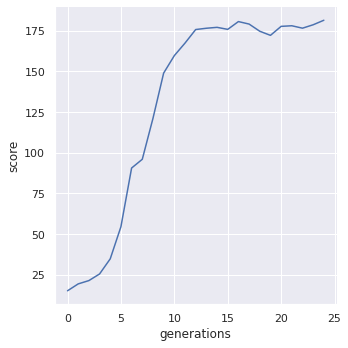

In [4]:
import seaborn as sns
sns.set_theme()
sns.relplot(data=pop_fit, kind="line").set(xlabel='generations', ylabel='score')